# Melting behaviour of Crystals

This notebook is focused on
understanding the melting behaviour of
each of the different crystal structures.
This is a more qualitative rather than quantitative
investigation of the behaviour.

In [1]:
import pandas
import altair as alt
import gsd.hoomd
from bokeh.io import export_svgs

from sdanalysis import HoomdFrame
from sdanalysis.figures import plot_frame, show, output_notebook

import sys
sys.path.append('../src')
import detection
import figures

alt.data_transformers.enable('csv')
figures.use_my_theme()
output_notebook()

Loading BokehJS ...

## Data Source

The data is sources from the melting_clean.h5 file
generated from the data in the `interface` simulations directory.
This contains simulations over a long time period
close to the melting points of the crystals.

In [2]:
with pandas.HDFStore("../data/analysis/melting_clean.h5") as src:
    df = src.get("fractions")
df.columns

Index(['crystal', 'iter_id', 'liq', 'p2', 'p2gg', 'pg', 'pressure',
       'surface_area', 'temperature', 'time', 'volume', 'radius'],
      dtype='object')

To get the dataset in an appropriate format for plotting
it needs to go through a restructuring,
this is done using the `melt` function.

In [3]:
df = df.melt(id_vars=["crystal", "iter_id", "time", "temperature", "pressure"]).query(
    "variable in ['p2', 'p2gg', 'pg']"
)

## Solid State Phase Transition

The first result here is the unusual behaviour of the p2gg crystal in the solid state.
This is highlighted by the image below.
Here we have a

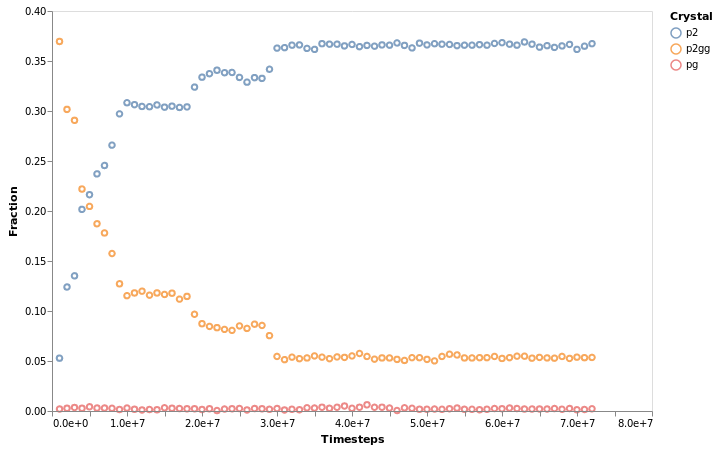

In [4]:
c = alt.Chart(
    df.query("temperature == 1.37 and pressure == 13.50 and crystal == 'p2gg'")
).mark_point().encode(
    x=alt.X("time", title="Timesteps", axis=alt.Axis(format="e")),
    y=alt.Y("value", title="Fraction"),
    color=alt.Color("variable", title="Crystal"),
)
c

In [5]:
c.save("../figures/solid_state_transition-P13.50-T1.37-p2gg.svg", webdriver="firefox")

In [6]:
with pandas.HDFStore("../data/analysis/dynamics_clean_agg.h5") as src:
    df_dynamics = src.get("relaxations")
rot_relaxation = df_dynamics.query("temperature == 1.37 and pressure == 13.50")["rot2_value"]
print(f"The rotational relaxation time is {rot_relaxation.values[0]:.2e}")

The rotational relaxation time is 5.37e+06


Comparing this solid state transition
with the rotational relaxation time,
which is $~\SI{5e6}$,
the transition takes place remarkably quickly,
on the order of only a few rotational relaxation times,
which is orders of magnitude faster than the melting.

Another figure which better shows the relationship
between the solid state rearrangement
and the melting rate is at a temperature of 1.46.
Here the solid state rearrangement takes place quickly,
followed by a much slower and more gradual melting.

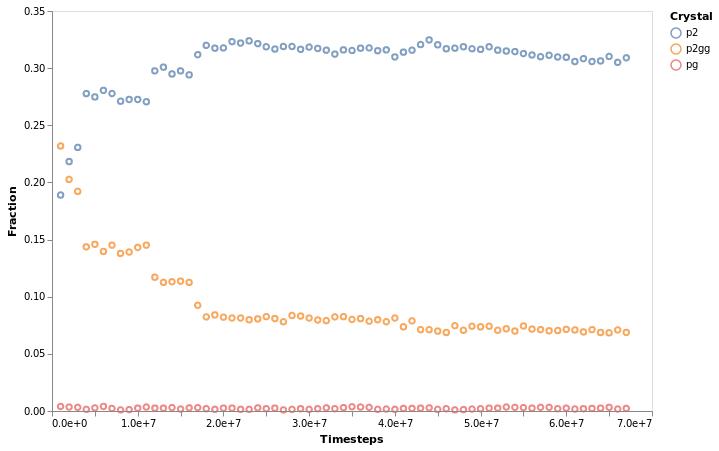

In [7]:
c = alt.Chart(df.query("temperature ==1.46 & pressure == 13.50 & crystal == 'p2gg'")
).mark_point().encode(
    x=alt.X("time", title="Timesteps", axis=alt.Axis(format="e")),
    y=alt.Y("value", title="Fraction"),
    color=alt.Color("variable", title="Crystal"),
)
c

In [8]:
c.save("../figures/solid_state_transition-P13.50-T1.46-p2gg.svg", webdriver="firefox")

One of the features of the solid state transition
is the stepped nature of the transition,
It will proceed quickly,
halt for some time,
then proceed again quickly.
To understand how this process is taking place
it would be really useful to understand
why these unusual features are present.
To do this we need to look at
the configurations themselves.

In [9]:
trajectory_file  = "../data/simulations/interface/output/dump-Trimer-P13.50-T1.37-p2gg.gsd"
with gsd.hoomd.open(trajectory_file) as trj:
    snap_init = HoomdFrame(trj[0])
    snap_process = HoomdFrame(trj[400])
    snap_end = HoomdFrame(trj[-1])

In [10]:
snap_process.timestep

4000000

In [11]:
snap_end.timestep

72360000

In [12]:
import joblib
import functools
from sdanalysis.order import compute_ml_order
knn = joblib.load("../models/knn-trimer.pkl")

In [13]:
categories = compute_ml_order(knn, snap_init.box, snap_init.position, snap_init.orientation)
frame = plot_frame(snap_init, order_list=categories, categorical_colour=True)
frame = figures.style_snapshot(frame)
show(frame)

In [14]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.37-p2gg_init.svg")

['../figures/configuration-P13.50-T1.37-p2gg_init.svg']

# categories = compute_ml_order(knn, snap_process.box, snap_process.position, snap_process.orientation)
frame = plot_frame(snap_process, order_list=categories, categorical_colour=True)
frame = figures.style_snapshot(frame)
show(frame)

In [15]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.37-p2gg_process.svg")

['../figures/configuration-P13.50-T1.37-p2gg_process.svg']

In [16]:
categories = compute_ml_order(knn, snap_end.box, snap_end.position, snap_end.orientation)
frame = plot_frame(snap_end, order_list=categories, categorical_colour=True)
frame = figures.style_snapshot(frame)
show(frame)

In [17]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.37-p2gg_end.svg")

['../figures/configuration-P13.50-T1.37-p2gg_end.svg']

## Melting pg Crystal

While the 

In [18]:
groupbys = list(df.columns)
groupbys.remove('variable')
groupbys.remove('value')

In [19]:
df_melt = df.groupby(groupbys).sum().reset_index()

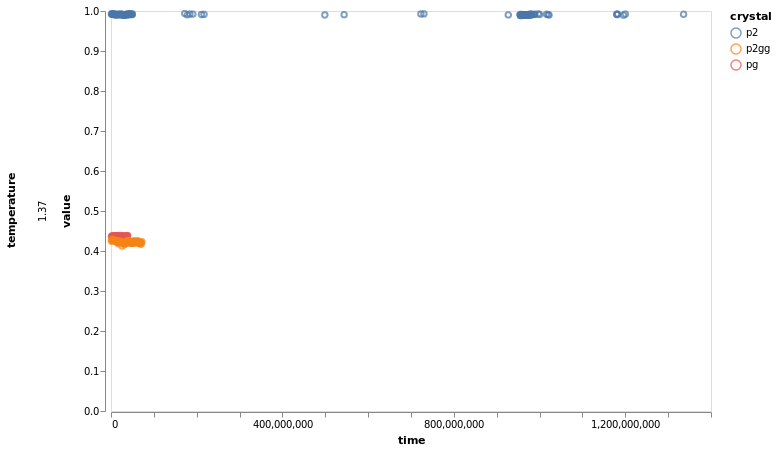

In [20]:
alt.Chart(df_melt.query("pressure==13.50 and temperature == 1.37")).mark_point().encode(
    x="time",
    y="value",
    color="crystal",
    row="temperature"
)

In [21]:
trajectory_file  = "../data/simulations/interface/output/dump-Trimer-P13.50-T1.42-pg.gsd"
with gsd.hoomd.open(trajectory_file) as trj:
    snap_init = HoomdFrame(trj[0])
    snap_process = HoomdFrame(trj[20_000])
    snap_end = HoomdFrame(trj[40_000])

In [22]:
snap_process.timestep

200000000

In [23]:
categories = compute_ml_order(knn, snap_init.box, snap_init.position, snap_init.orientation)
frame = plot_frame(snap_init, order_list=categories, categorical_colour=True)
frame = figures.style_snapshot(frame)
show(frame)

In [24]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.42-pg_0.svg")

['../figures/configuration-P13.50-T1.42-pg_0.svg']

In [25]:
from bokeh.models import Range1d
frame.x_range = Range1d(-15, 15)
frame.y_range = Range1d(40, 65)
show(frame)

In [26]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.42-pg_top_0.svg")

['../figures/configuration-P13.50-T1.42-pg_top_0.svg']

In [27]:
frame.x_range = Range1d(-15, 15)
frame.y_range = Range1d(-65, -40)
show(frame)

In [28]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.42-pg_bottom_0.svg")

['../figures/configuration-P13.50-T1.42-pg_bottom_0.svg']

In [29]:
categories = compute_ml_order(knn, snap_process.box, snap_process.position, snap_process.orientation)
frame = plot_frame(snap_process, order_list=categories, categorical_colour=True)
frame = figures.style_snapshot(frame)
show(frame)

In [30]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.42-pg_1.svg")

['../figures/configuration-P13.50-T1.42-pg_1.svg']

In [31]:
show(frame)

In [32]:
categories = compute_ml_order(knn, snap_end.box, snap_end.position, snap_end.orientation)
frame = plot_frame(snap_end, order_list=categories, categorical_colour=True)
frame = figures.style_snapshot(frame)
show(frame)

In [33]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.42-pg_2.svg")

['../figures/configuration-P13.50-T1.42-pg_2.svg']

In [34]:
frame.x_range = Range1d(-15, 15)
frame.y_range = Range1d(40, 65)
show(frame)

In [35]:
frame.output_backend = "svg"
export_svgs(frame, "../figures/configuration-P13.50-T1.42-pg_top_2.svg")

['../figures/configuration-P13.50-T1.42-pg_top_2.svg']